## import

In [1]:
from pathlib import Path

import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import Fcn
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/fcn")
data_path = Path("../../data")

In [3]:
device = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)


In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)


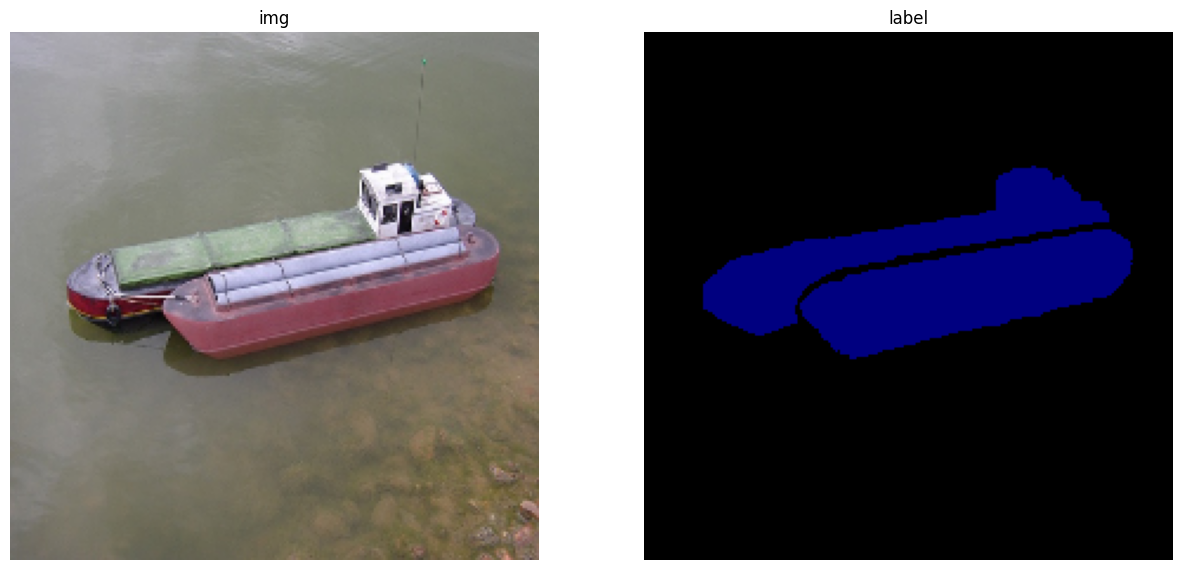

In [8]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [9]:
model = Fcn(20 + 1).to(device)


In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Fcn                                      --
├─FeatureExtractor: 1-1                  --
│    └─ImageNormalization: 2-1           --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17             

In [11]:
model_path = artifacts_path.joinpath('fcn.pth')

# train

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
EPOCHES = 15

In [14]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)
        label = label.long().to(device)

        output = model(img).float()
        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"epoch {e+1}: {running_loss/len(train_dataset)}")


  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 91/91 [00:30<00:00,  2.95it/s]


epoch 1: 0.07351134746622229


100%|██████████| 91/91 [00:28<00:00,  3.18it/s]


epoch 2: 0.04615477098863722


100%|██████████| 91/91 [00:27<00:00,  3.26it/s]


epoch 3: 0.03757697425672699


100%|██████████| 91/91 [00:30<00:00,  2.97it/s]


epoch 4: 0.03291587440000954


100%|██████████| 91/91 [00:29<00:00,  3.06it/s]


epoch 5: 0.03003669073603794


100%|██████████| 91/91 [00:29<00:00,  3.11it/s]


epoch 6: 0.028816583698408896


100%|██████████| 91/91 [00:28<00:00,  3.25it/s]


epoch 7: 0.02678586474571529


100%|██████████| 91/91 [00:27<00:00,  3.29it/s]


epoch 8: 0.025403677598741757


100%|██████████| 91/91 [00:27<00:00,  3.30it/s]


epoch 9: 0.024264468284885866


100%|██████████| 91/91 [00:27<00:00,  3.29it/s]


epoch 10: 0.023570180328040445


100%|██████████| 91/91 [00:27<00:00,  3.29it/s]


epoch 11: 0.022793028492146736


100%|██████████| 91/91 [00:27<00:00,  3.26it/s]


epoch 12: 0.021800211582485032


100%|██████████| 91/91 [00:28<00:00,  3.24it/s]


epoch 13: 0.02126864567680372


100%|██████████| 91/91 [00:27<00:00,  3.26it/s]


epoch 14: 0.020345319700617582


100%|██████████| 91/91 [00:27<00:00,  3.25it/s]

epoch 15: 0.019288368142023556


In [ ]:
# torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), "fcn.onnx")
torch.save(model.state_dict(), model_path)

# 62.8 MB

# inference

In [ ]:
model.load_state_dict(torch.load(model_path))

In [16]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)


In [17]:
test_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)


### dice coef

In [21]:
model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(21):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 92/92 [00:41<00:00,  2.20it/s]


In [23]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.3341938
bicycle 0.0002111228
bird 0.13837057
boat 0.01038336
bottle 0.012593253
bus 0.40635225
car 0.44682336
cat 0.46049094
chair 2.666089e-05
cow 0.012404986
diningtable 0.0863086
dog 0.26672545
horse 0.22464894
motorbike 0.32870507
person 0.69399774
pottedplant 0.008893095
sheep 0.1446465
sofa 0.018250182
train 0.13730443
tvmonitor 0.00046763002
mean dice: 0.1865899


### for image in dataset

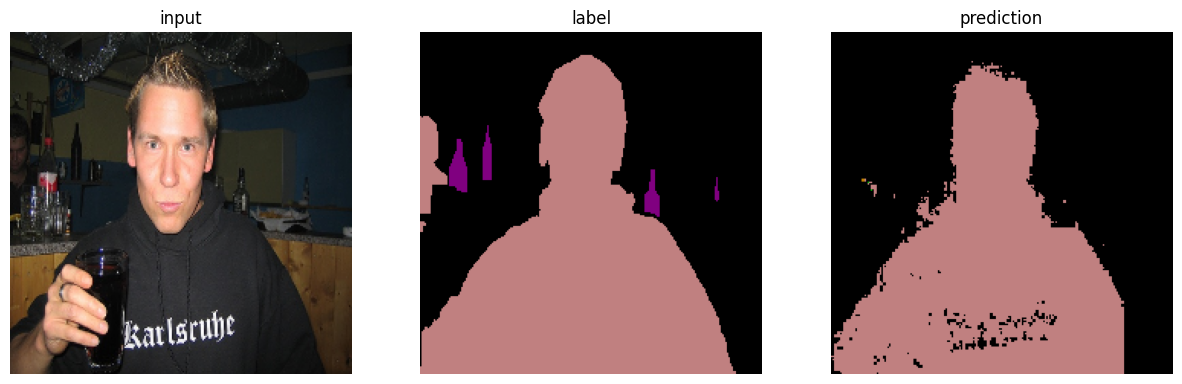

In [19]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(device))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

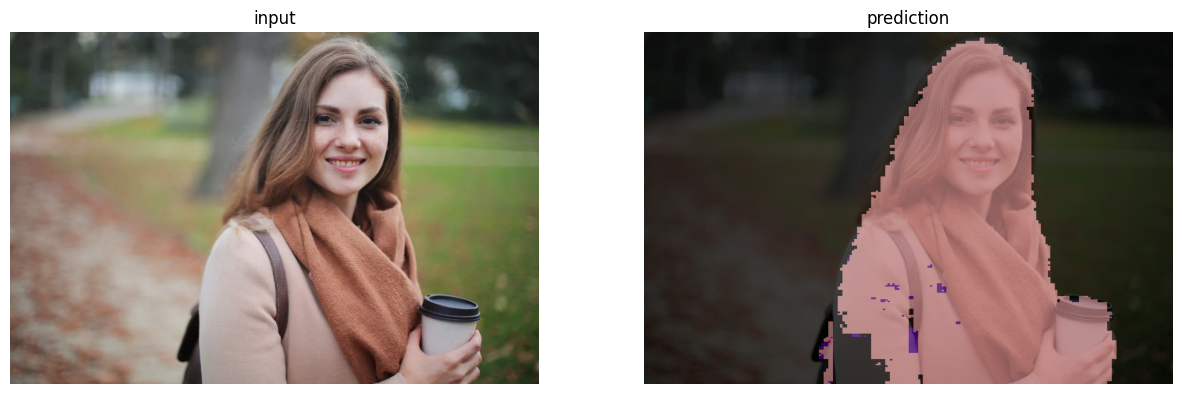

In [68]:
model.eval()
with torch.no_grad():
    target_img = load_image(artifacts_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(device))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )